In [1]:
!pip install albumentations > /dev/null

You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install pretrainedmodels > /dev/null

You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!conda install -y pandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/mahesh/anaconda3/envs/pytorch-env

  added / updated specs: 
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandas-0.24.1              |   py36he6710b0_0        11.1 MB

The following NEW packages will be INSTALLED:

    pandas: 0.24.1-py36he6710b0_0


pandas-0.24.1        | 11.1 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [5]:
import os

import albumentations
from albumentations import torch as AT
import pretrainedmodels

import numpy as np
import pandas as pd

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [6]:
train_df = pd.read_csv("../whale-data/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
train_df.shape, train_df.Id.nunique()

((25361, 2), 5005)

In [8]:
NUM_CLASSES = train_df.Id.nunique()

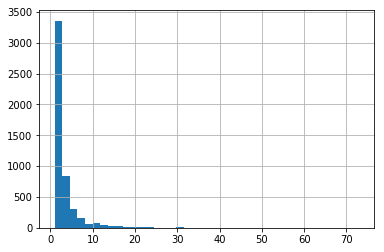

In [9]:
train_df.Id.value_counts().iloc[1:].hist(bins=40)

In [10]:
RESIZE_H = 160
RESIZE_W = 320

data_transforms = albumentations.Compose([
    albumentations.Resize(RESIZE_H, RESIZE_W),
    albumentations.HorizontalFlip(),
    albumentations.OneOf([
        albumentations.RandomContrast(),
        albumentations.RandomBrightness(),
    ]),
    albumentations.ShiftScaleRotate(rotate_limit=10, scale_limit=0.15),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(RESIZE_H, RESIZE_W),
    albumentations.Normalize(),
    AT.ToTensor()
])

In [11]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [12]:
y, lab_encoder = prepare_labels(train_df['Id'])

/home/mahesh/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform=None, y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((NUM_CLASSES,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [14]:
train_dataset = WhaleDataset(
    datafolder='../whale-data/train/', 
    datatype='train', 
    df=train_df, 
    transform=data_transforms, 
    y=y
)

test_set = WhaleDataset(
    datafolder='../whale-data/test/', 
    datatype='test', 
    transform=data_transforms_test
)

In [15]:
batch_size = 10
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [16]:
model = pretrainedmodels.resnext101_64x4d()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/resnext101_64x4d-e77a0586.pth" to /home/mahesh/.torch/models/resnext101_64x4d-e77a0586.pth
100%|██████████| 334703243/334703243 [02:06<00:00, 2645012.98it/s]


In [17]:
model.avg_pool = nn.AvgPool2d((5,10))

In [18]:
model.last_linear = nn.Linear(model.last_linear.in_features, NUM_CLASSES)

In [19]:
model.cuda();

In [20]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [21]:
def cuda(x):
    return x.cuda(non_blocking=True) if torch.cuda.is_available() else x

In [22]:
n_epochs = 5
for epoch in range(1, n_epochs+1):
    train_loss = []
    
    for batch_i, (data, target) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data, target = cuda(data), cuda(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

100%|██████████| 2537/2537 [22:57<00:00,  2.17it/s]

Epoch 1, train loss: 0.0023



100%|██████████| 2537/2537 [22:43<00:00,  2.18it/s]

Epoch 2, train loss: 0.0012



100%|██████████| 2537/2537 [22:57<00:00,  2.18it/s]

Epoch 3, train loss: 0.0011



100%|██████████| 2537/2537 [22:56<00:00,  2.18it/s]

Epoch 4, train loss: 0.0009



100%|██████████| 2537/2537 [22:56<00:00,  2.20it/s]

Epoch 5, train loss: 0.0006


In [23]:
sub = pd.read_csv('../whale-data/sample_submission.csv')

model.eval()
for (data, target, name) in tqdm(test_loader):
    data = cuda(data)
    output = model(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(lab_encoder.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)

100%|██████████| 796/796 [02:12<00:00,  5.90it/s]
